### Note: I simply ran this notebook twice for type "old" and "new" to generate models and plots

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import sys
from pathlib2 import Path

# NOTE these two lines (especially the second one) are somewhat dangerous 
# and you'd better just add path to this repo to PYTHONPATH
# but this should work!
sys.path.append(Path.cwd().parent.as_posix())
sys.path.append(Path.cwd().parent.parent.as_posix())



In [3]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.size"] = 14

In [23]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.size"] = 14

In [6]:
import load_surfaces, training, dplot, utils, paths
from importlib import reload

def RELOAD():
    reload(load_surfaces)
    reload(training)
    reload(dplot)
    reload(utils)
    reload(paths)
    
RELOAD()

### Choose which data to load: old or new

In [7]:
TYPE = "new"
assert TYPE in ["old", "new"]

In [8]:
raw_data = load_surfaces.load_vlt_surfaces(TYPE)

raw_data.keys()

Loading 53354 surfaces...


dict_keys(['params_nk', 'vols_nms', 'params_cols_k', 'mat_ms', 'strikes_ms'])

In [9]:
normalized_data = utils.get_train_test_split_nk_nf(raw_data)
normalized_data.keys()

dict_keys(['params_train_nk', 'vol_train_nf', 'params_test_Nk', 'vol_test_Nf', 'params_scaler', 'vol_scaler'])

In [10]:
torch_data = training.get_train_test_dataset_and_loader(normalized_data, batch_size=512)

### Define model and fit

In [11]:
import matplotlib.pyplot as plt

In [12]:
model = training.get_torch_model(raw_data["params_nk"].shape[1], num_layers=4)
learner = training.Learner(model, torch_data["train_loader"], torch_data["test_loader"])

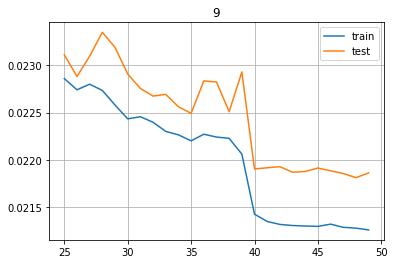

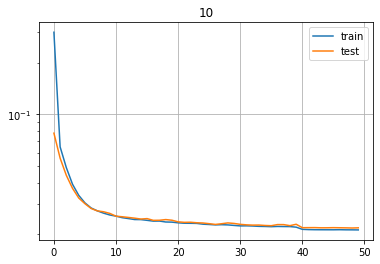

In [13]:
learner.train(40)
learner.optimizer.param_groups[0]["lr"] *= 0.1
fig = learner.train(10)

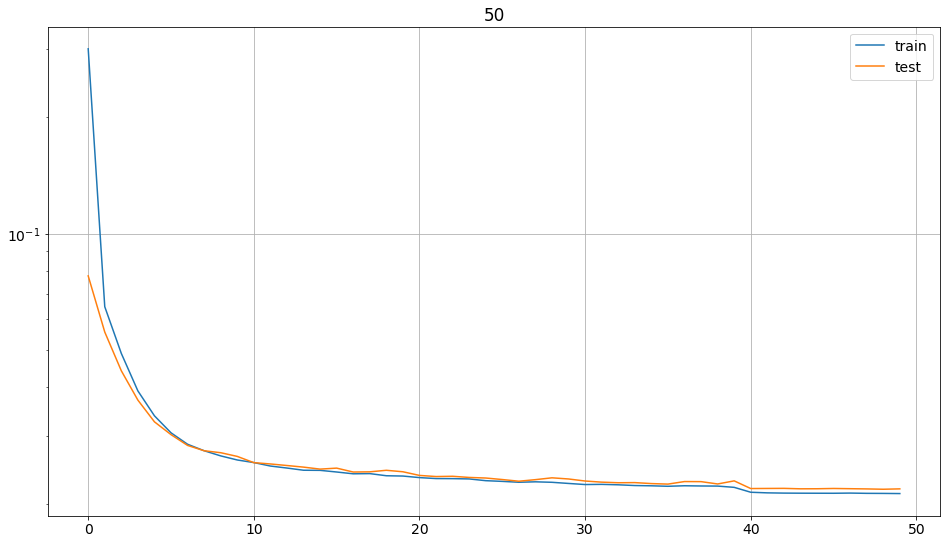

In [24]:
fig = learner.show_loss(50)

In [25]:
fig.savefig(f"../images/loss_by_epoch_{TYPE}.png")

### Save the model

In [26]:
paths.PATH_TO_MODELS.mkdir(exist_ok=True)
learner.model.eval()

Sequential(
  (0): Linear(in_features=11, out_features=30, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=30, out_features=88, bias=True)
)

In [27]:
bounds = list(zip(normalized_data["params_train_nk"].min(axis=0),
                  normalized_data["params_train_nk"].max(axis=0)))

In [28]:
torch.save(normalized_data["params_scaler"], str(paths.PATH_TO_MODELS/f"params_scaler_{TYPE}.pt"))
torch.save(normalized_data["vol_scaler"],    str(paths.PATH_TO_MODELS/f"vol_scaler_{TYPE}.pt"))
torch.save(bounds,                           str(paths.PATH_TO_MODELS/f"bounds_{TYPE}.pt"))
torch.save(learner.model,                    str(paths.PATH_TO_MODELS/f"model_{TYPE}.pt"))

### Plot errors

In [29]:
def calculate_errors(learner, torch_data, normalized_data):
    pred_surf_nms, target_surf_nms =\
        learner.predict(torch_data["test_dataset"], normalized_data["vol_scaler"])

    mse_ms = np.sqrt(((pred_surf_nms - target_surf_nms)**2).mean(axis=0))
    mse_ms /= target_surf_nms.mean(axis=0)
    return mse_ms
    
def plot_errors(mse_ms, raw_data, TYPE=TYPE):
    fig, axis = plt.subplots(1,1)
    axis.set_title(f"average relative error ({TYPE})")

    axis.set_yticks(np.arange(8))
    axis.set_xticks(np.arange(11))
    img = axis.imshow(mse_ms[::-1])

    axis.set_ylabel("maturity in years")
    axis.set_yticklabels(np.around(raw_data["mat_ms"][::-1, 0], 3))
    axis.set_xlabel(f"log strike at {raw_data['mat_ms'][3, 0] :.3f} years")
    axis.set_xticklabels(
        np.around(np.log(raw_data["strikes_ms"][3, :]), 3),
        rotation=30, ha="right")

    fig.colorbar(img)
    return fig

In [30]:
mse_ms = calculate_errors(learner, torch_data, normalized_data)

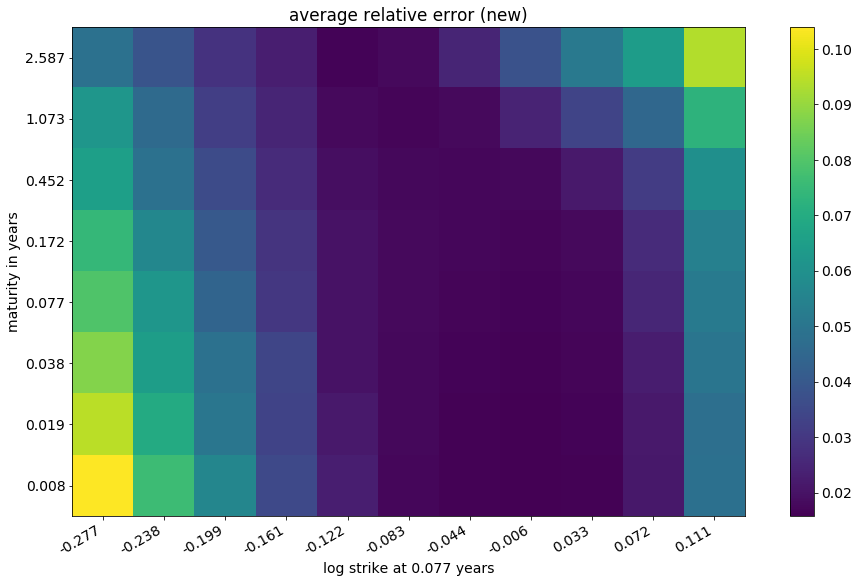

In [31]:
fig = plot_errors(mse_ms, raw_data, TYPE)

In [32]:
fig.savefig(f"../images/relative_error_{TYPE}.png")